# How transfers can affect a fantasy teams points?

Over the course of the season, transfers will have to be made due to injuries, suspensions, fixtures and underperforming players, or even bringing in a top performer. Each FPL player is given one free transfer each week, extra transfers subtract points from a players points total. Transfers may only be made when budget and team constraints are met. 

In [156]:
import os
import math
import itertools
import re
import random
from collections import OrderedDict
from pathlib import Path
import multiprocessing as mp
from datetime import datetime
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from loguru import logger
from scipy.stats import linregress
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from scipy.stats import zscore
sns.set(style="white")
%matplotlib inline

In [157]:
os.chdir('../data') 
gws_data = 'clean/20_21/gws20_21.pkl'
teams_data = 'clean/20_21/teams20_21.pkl'
fixtures_data = 'clean/20_21/fixtures20_21.pkl'
gws = pd.read_pickle(gws_data)
teams = pd.read_pickle(teams_data)
fixtures = pd.read_pickle(fixtures_data)
gws

,id,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw
gw,,,,,,,,,,,,,,,,,,,,,
1,3,David Luiz Moreira Marinho,DEF,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,55.0,False,0.0,1
1,4,Pierre-Emerick Aubameyang,MID,Arsenal,5.0,0.0,0.0,19.0,1.0,15.3,...,0.0,54.0,7.0,0.0,0.0,0.0,120.0,False,1.0,1
1,5,Cédric Soares,DEF,Arsenal,3.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,False,0.0,1
1,6,Alexandre Lacazette,FWD,Arsenal,4.0,0.0,1.0,29.0,0.0,12.7,...,0.0,48.0,7.0,0.0,0.0,0.0,85.0,False,0.0,1
1,7,Shkodran Mustafi,DEF,Arsenal,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,False,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,563,Rayan Ait Nouri,DEF,Wolves,-0.5,0.0,0.0,5.0,0.0,1.9,...,1.0,19.0,0.0,-501.0,270.0,771.0,50.0,True,1.0,38
38,581,Owen Otasowie,MID,Wolves,-0.1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-13.0,12.0,25.0,45.0,True,0.0,38
38,610,Theo Corbeanu,MID,Wolves,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,129.0,190.0,61.0,44.0,True,0.0,38


In [158]:
teams = teams.reset_index(drop=True)
teams_strength = teams[['id','strength']]
teams_strength = teams_strength.rename(columns = {'id':'opponent_team', 'strength':'opponent_strength'})
teams_strength['opponent_team'] = pd.to_numeric(teams_strength['opponent_team'], downcast='integer')

gws_info = gws[['id', 'name','position','team','total_points','xP','selected','transfers_in','transfers_out','value','gw','opponent_team','minutes']]
gws_info['value'] = gws_info['value'].div(10)
gws_info = gws_info[gws_info['value'].notna()]
gws_info = gws_info[gws_info['selected'].notna()]
gws_info = gws_info[gws_info['selected'] >= 1]
gws_info = gws_info[gws_info['minutes']!=0]
gws_info['opponent_team'] = pd.to_numeric(gws_info['opponent_team'], downcast='integer')
gws_info = pd.merge(gws_info, teams_strength, on='opponent_team')
gws_info

C:\Users\phili\AppData\Local\Temp\ipykernel_9876\1539383160.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gws_info['value'] = gws_info['value'].div(10)


,id,name,position,team,total_points,xP,selected,transfers_in,transfers_out,value,gw,opponent_team,minutes,opponent_strength
0,4,Pierre-Emerick Aubameyang,MID,Arsenal,7.0,5.0,2823465.0,0.0,0.0,12.0,1,8,90.0,3
1,6,Alexandre Lacazette,FWD,Arsenal,7.0,4.0,196064.0,0.0,0.0,8.5,1,8,86.0,3
2,8,Bernd Leno,GK,Arsenal,7.0,3.5,400285.0,0.0,0.0,5.0,1,8,90.0,3
3,9,Granit Xhaka,MID,Arsenal,3.0,2.8,42909.0,0.0,0.0,5.5,1,8,77.0,3
4,11,Héctor Bellerín,DEF,Arsenal,5.0,3.1,240975.0,0.0,0.0,5.0,1,8,90.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,166,Richarlison de Andrade,FWD,Everton,1.0,0.0,579899.0,4409.0,48139.0,7.7,38,12,77.0,5
10387,502,Allan Marques Loureiro,MID,Everton,2.0,1.0,49595.0,142.0,202.0,5.2,38,12,90.0,5
10388,512,Abdoulaye Doucouré,MID,Everton,1.0,0.0,50749.0,191.0,364.0,5.1,38,12,56.0,5
10389,559,Niels Nkounkou,DEF,Everton,1.0,0.0,13624.0,145.0,164.0,4.0,38,12,12.0,5


# Transfers In and Points

count    1.039100e+04
mean     2.951218e+04
std      7.972807e+04
min      0.000000e+00
25%      6.120000e+02
50%      3.750000e+03
75%      1.955900e+04
max      1.991731e+06
Name: transfers_in, dtype: float64


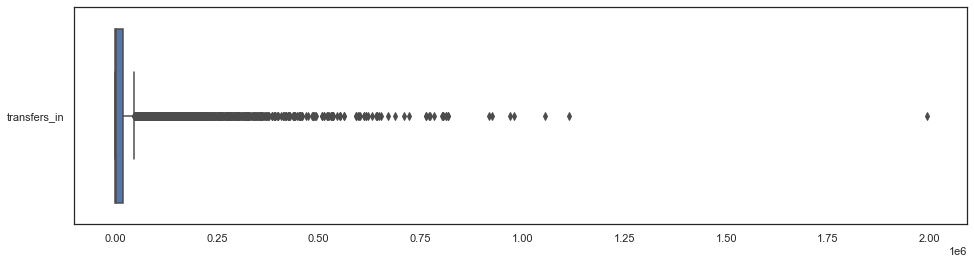

In [159]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(data= gws_info[['transfers_in']], orient='h')

print(gws_info['transfers_in'].describe())

Players with more than 8017.5, lie within the top 25% of transfers in a single gameweek.

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

r2 = 0


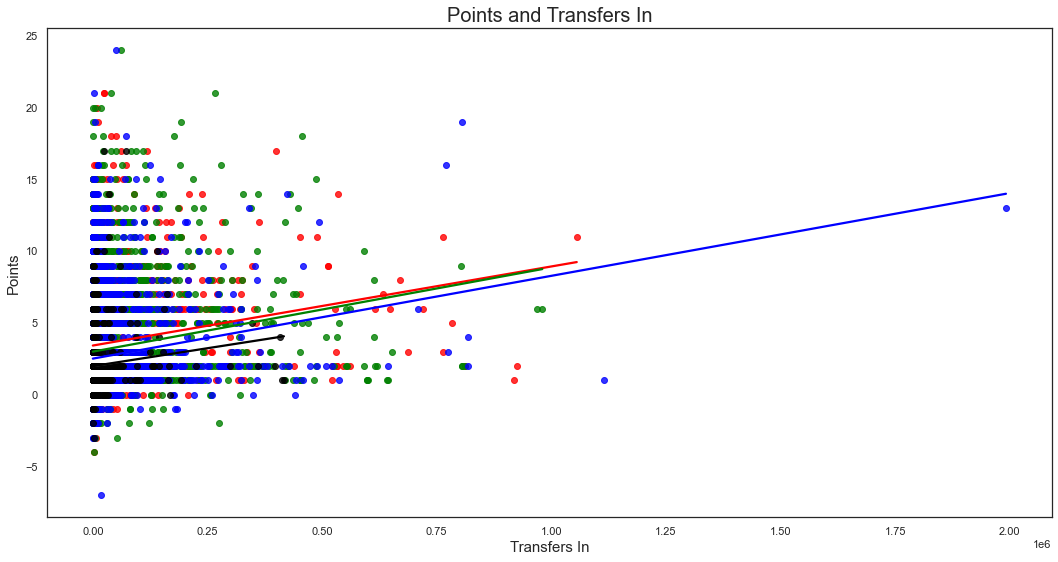

In [160]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(2)['transfers_in'], gws_info.groupby('opponent_strength').get_group(2)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'red'
)

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(3)['transfers_in'], gws_info.groupby('opponent_strength').get_group(3)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'green'
)

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(4)['transfers_in'], gws_info.groupby('opponent_strength').get_group(4)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'blue'
)

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(5)['transfers_in'], gws_info.groupby('opponent_strength').get_group(5)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'black'
)
ax.set_title('Points and Transfers In', fontsize = 20)
ax.set_xlabel('Transfers In', fontsize = 15)
ax.set_ylabel('Points', fontsize = 15)

print('r2 = ' + str(round(r2_score(gws_info['transfers_in'], gws_info['total_points']))))

In [161]:
os.chdir('../figs')

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


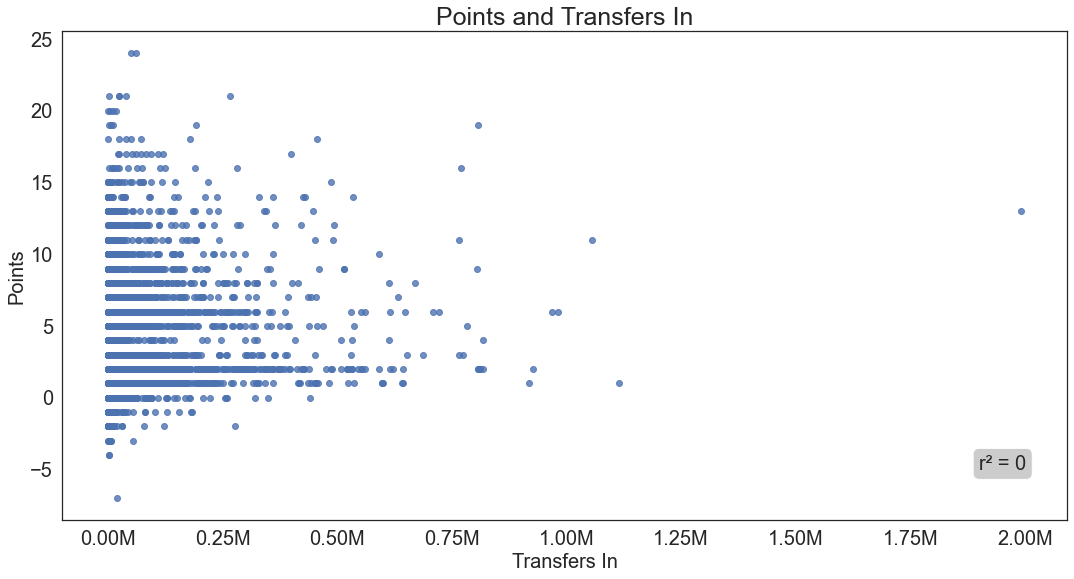

In [162]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")
def millions(x, pos):
    return '{:1.2f}M'.format(x*1e-6)

sns.regplot(
    gws_info['transfers_in'], gws_info['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=False
).annotate('r² = ' + str(round(r2_score(gws_info['transfers_in'], gws_info['total_points']))),
           xy=(1900000,-5), fontsize = 20, bbox = bbox)

ax.set_title('Points and Transfers In', fontsize = 25)
ax.set_xlabel('Transfers In', fontsize = 20)
ax.set_ylabel('Points', fontsize = 20)
ax.tick_params(labelsize=20)
ax.ticklabel_format(useOffset=False, style='plain', axis='x')
ax.xaxis.set_major_formatter(millions)
fig.savefig("transfers_points1.png")

We see no relationship between points and transfers in here, so we will calculate the z-scores for transfers in as many players are not transferred frequently because they are already owned by a lot of managers.

In [163]:
#Calculating transfers z-scores
t_in = gws_info.reset_index(drop=True)
t_in = t_in.groupby(['name'], as_index=True )['transfers_in'].apply(lambda df: df.reset_index(drop=True)).unstack()
k = list(range(38,40))
t_in = t_in.drop(t_in.columns[k], axis = 1)
t_in = t_in.fillna(0)
t_in = t_in.T
t_in = t_in.apply(zscore,axis=1)
t_in.index += 1 
t_in = t_in.stack().reset_index(drop=False)
t_in = t_in.rename(columns = {'level_0':'gw', 0:'z_score_transin'})

var_t_in = t_in.var().sort_values(ascending=False)

p_in = gws_info.reset_index(drop=True)
p_in = p_in.groupby(['name'], as_index=True )['total_points'].apply(lambda df: df.reset_index(drop=True)).unstack()
p_in = p_in.drop(p_in.columns[k], axis = 1)
p_in = p_in.fillna(0)
p_in = p_in.T
p_in = p_in.apply(zscore,axis=1)
p_in.index += 1 
p_in = p_in.stack().reset_index(drop=False)
p_in = p_in.rename(columns = {'level_0':'gw', 0:'z_score_points'})

merged = pd.merge(p_in, t_in, on=['name','gw'], how='outer')
gw_strengths = gws_info[['gw', 'name', 'opponent_strength']]
merged = pd.merge(merged, gw_strengths, on=['name','gw'])
merged = pd.merge(merged, gws_info[['name','gw','transfers_in','transfers_out', 'total_points']], on=['name','gw'])
merged = merged[merged['gw'] != 1]
top_merged = merged[merged['z_score_transin']>2]
top_merged = top_merged.drop_duplicates()
t_in

C:\Users\phili\AppData\Local\Temp\ipykernel_9876\725411962.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var_t_in = t_in.var().sort_values(ascending=False)


,gw,name,z_score_transin
0,1,Aaron Connolly,-0.398761
1,1,Aaron Cresswell,1.565972
2,1,Aaron Ramsdale,-0.075411
3,1,Aaron Wan-Bissaka,0.411037
4,1,Abdoulaye Doucouré,-0.370720
...,...,...,...
19603,38,Yerry Mina,-0.090734
19604,38,Youri Tielemans,2.097354
19605,38,Yves Bissouma,-0.090734
19606,38,Zack Steffen,-0.090734


C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


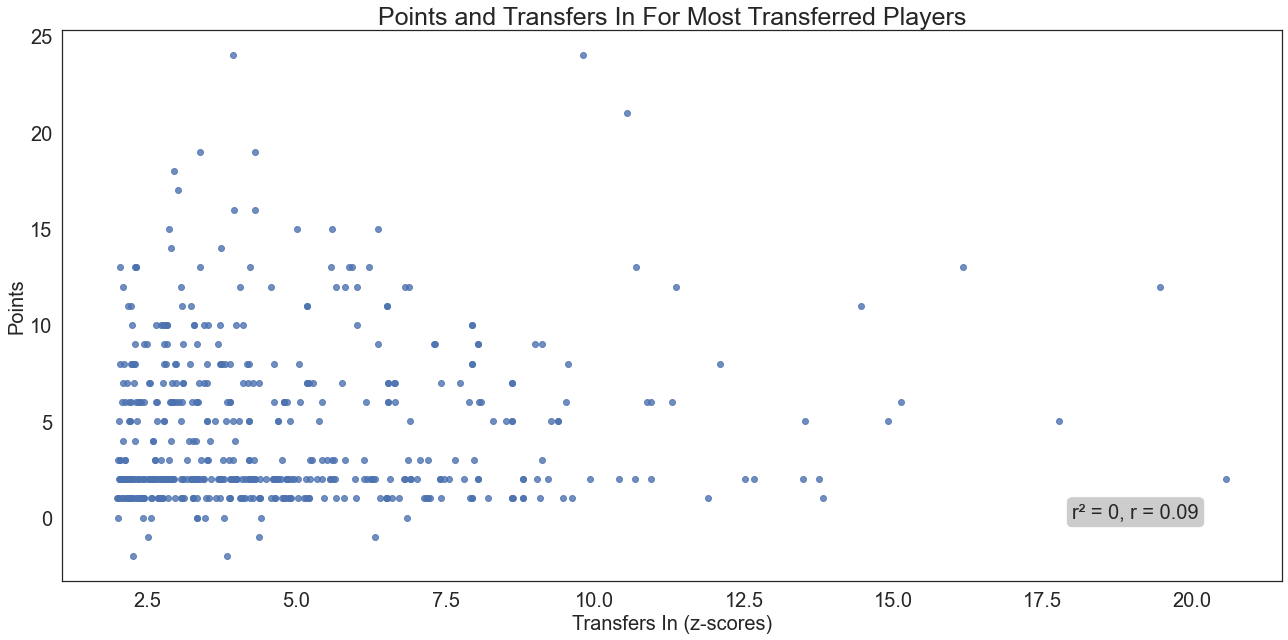

In [164]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

r_val = top_merged['z_score_transin'].corr(top_merged['total_points'])
r_val = round(r_val,2)

sns.regplot(
     top_merged['z_score_transin'],top_merged['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=False
).annotate('r² = ' + str(round(r2_score(gws_info['transfers_in'], gws_info['total_points']))) + ', r = ' + str(r_val),
           xy=(18,0), fontsize = 20, bbox = bbox)

ax.set_title('Points and Transfers In For Most Transferred Players', fontsize = 25)
ax.set_xlabel('Transfers In (z-scores)', fontsize = 20)
ax.set_ylabel('Points', fontsize = 20)
ax.tick_params(labelsize=20)
fig.tight_layout()
fig.savefig("transfers_points.png")

We still see no relationship between points scored and transfers-in so we will investigate the 'good' transfers where players scored highly and were transferred in a lot.

In [165]:
points_percent = (pd.value_counts(top_merged['total_points'], normalize=True).sort_index()).to_frame().reset_index()
points_percent_high = points_percent[points_percent['index'] >= 6] 
points_percent_lo = points_percent[points_percent['index'] <= 2] 
print('Percentage of high points from highly transferred players '+ str(float(points_percent_high['total_points'].sum() * 100)))
print('Percentage of low points from highly transferred players '+ str(float(points_percent_lo['total_points'].sum() * 100)))

Percentage of high points from highly transferred players 33.712121212121204
Percentage of low points from highly transferred players 51.89393939393939


In [166]:
most_trans_points = merged
most_trans_points= most_trans_points[most_trans_points['z_score_transin']>2]
most_trans_points = most_trans_points[most_trans_points['total_points']>=6]

xP = gws_info[['name','gw','xP', 'position']]
most_trans_points = pd.merge(most_trans_points, xP, on=['name','gw'])
most_trans_points = most_trans_points.drop_duplicates()

count = most_trans_points['opponent_strength'].value_counts()
data = pd.DataFrame(count)
num = float(data.sum())
data['opponent_strength'] = data['opponent_strength'].astype(float)
data['opponent_strength'] = (data['opponent_strength'] / num)*100

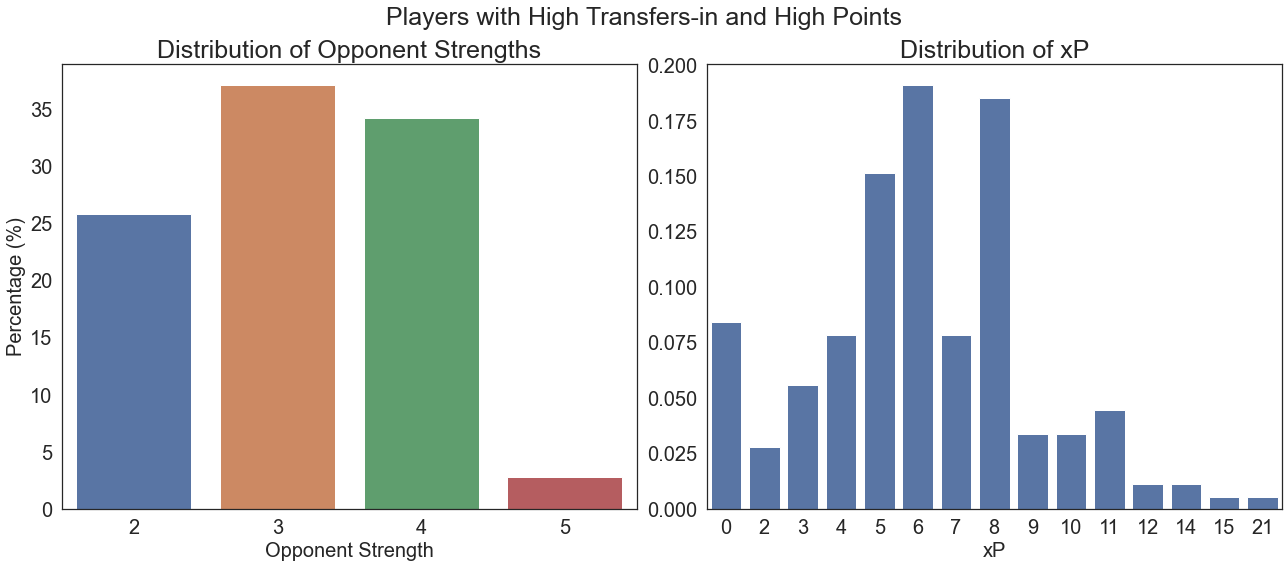

In [167]:
most_trans_points = most_trans_points.sort_values(by='total_points', ascending=False)
most_trans_points['xP'] = most_trans_points['xP'].round().astype(int)
xp = pd.value_counts(most_trans_points['xP'], normalize=True).sort_index()
xp_df = pd.DataFrame(xp)

fig, (ax,bx) = plt.subplots(figsize=(18, 8), ncols=2)
sns.barplot(x=data.index, y=data['opponent_strength'], ax=ax)
ax.set_title('Distribution of Opponent Strengths',fontsize=25)
ax.tick_params(labelsize=20)
ax.set_ylabel('Percentage (%)', fontsize = 20)
ax.set_xlabel('Opponent Strength', fontsize = 20)

sns.barplot(x= xp_df.index, y= xp_df['xP'], ax=bx, color= 'b')
bx.set_title('Distribution of xP',fontsize=25)
bx.tick_params(labelsize=20)
bx.set_ylabel('')
bx.set_xlabel('xP', fontsize = 20)

plt.suptitle('Players with High Transfers-in and High Points', fontsize=25)
fig.tight_layout()
fig.savefig('anomaly.png')

No obvious reason as to why players performed well when they had a high amount of transfers in.

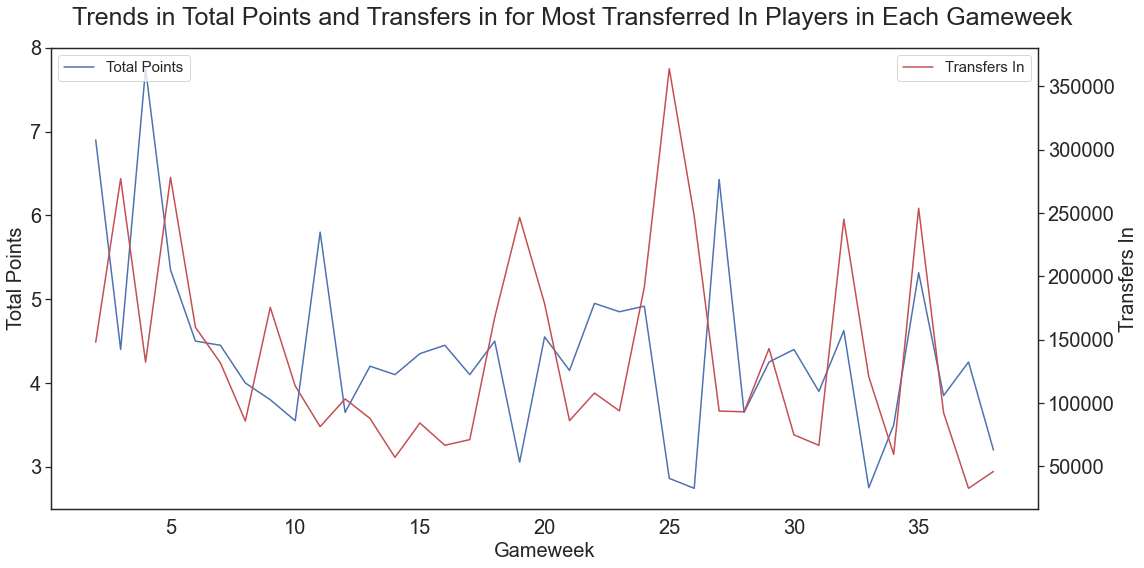

In [168]:
gw_info = gws_info.reset_index(drop=True)
merged = merged.sort_values(['gw', 'z_score_transin'], ascending=False).groupby('gw').head(20)
merged = merged[merged['gw'] !=1]
df_out = (merged.reset_index()[["name", "gw"]].merge(gw_info.reset_index(), on=["name", "gw"], how="inner"))
df_out = df_out.reset_index(drop=True).groupby('gw')

fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Trends in Total Points and Transfers in for Most Transferred In Players in Each Gameweek', fontsize=25)
plt.plot(df_out['total_points'].mean(), label = "Points")
plt.legend(['Total Points'], loc='upper left', fontsize = 15)
ax.set_xlabel('Gameweek', fontsize=20)
ax.set_ylabel('Total Points', fontsize=20)
ax2 = ax.twinx()
plt.plot(df_out['transfers_in'].mean(), label = "Transfers In", color='r')
plt.legend(['Transfers In'], loc='upper right', fontsize = 15)
ax2.set_ylabel('Transfers In', fontsize=20)
ax.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
fig.tight_layout()
fig.savefig('transfer_trends.png')

We see no relationship at all between transfers-in and points scored.

# Transfers Out and Points

count    1.039100e+04
mean     1.934915e+04
std      4.713203e+04
min      0.000000e+00
25%      9.485000e+02
50%      4.777000e+03
75%      1.826200e+04
max      1.380165e+06
Name: transfers_out, dtype: float64


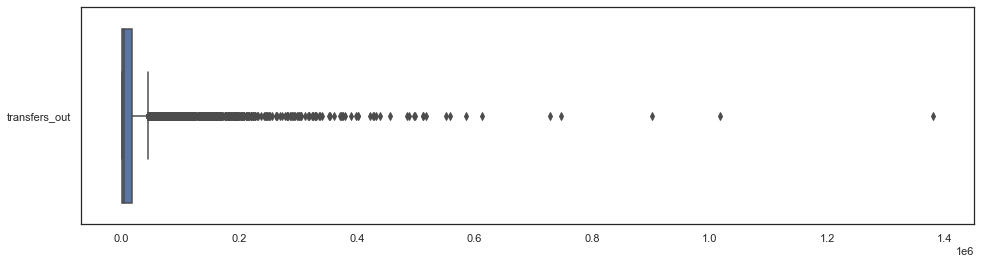

In [169]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(data= gws_info[['transfers_out']], orient='h')

print(gws_info['transfers_out'].describe())

r2 = 0


C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

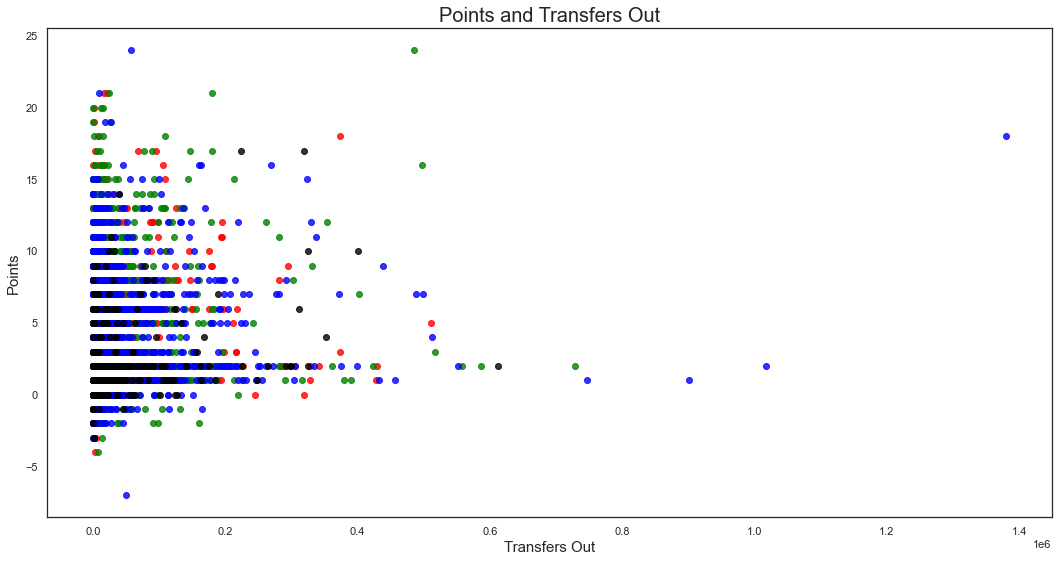

In [170]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(2)['transfers_out'], gws_info.groupby('opponent_strength').get_group(2)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=False, color = 'red'
)

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(3)['transfers_out'], gws_info.groupby('opponent_strength').get_group(3)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=False, color = 'green'
)

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(4)['transfers_out'], gws_info.groupby('opponent_strength').get_group(4)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=False, color = 'blue'
)

sns.regplot(
    gws_info.groupby('opponent_strength').get_group(5)['transfers_out'], gws_info.groupby('opponent_strength').get_group(5)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=False, color = 'black'
)
ax.set_title('Points and Transfers Out', fontsize = 20)
ax.set_xlabel('Transfers Out', fontsize = 15)
ax.set_ylabel('Points', fontsize = 15)

print('r2 = ' + str(round(r2_score(gws_info['transfers_out'], gws_info['total_points']))))

In [171]:
t_out = gws_info.reset_index(drop=True)
t_out = t_out.groupby(['name'], as_index=True )['transfers_out'].apply(lambda df: df.reset_index(drop=True)).unstack()
t_out = t_out.drop(t_out.columns[[38,39]], axis = 1)
t_out = t_out.fillna(0)
t_out = t_out.T
t_out = t_out.apply(zscore,axis=1)
t_out.index += 1 
t_out = t_out.stack().reset_index(drop=False)
t_out = t_out.rename(columns = {'level_0':'gw', 0:'z_score_transout'})

t_out

merged_tout = pd.merge(p_in, t_out, on=['name','gw'], how='outer')
gw_strengths = gws_info[['gw', 'name', 'opponent_strength']]
merged_tout = pd.merge(merged_tout, gw_strengths, on=['name','gw'])
merged_tout = pd.merge(merged_tout, gws_info[['name','gw','transfers_in','transfers_out', 'total_points']], on=['name','gw'])
merged_tout = merged_tout[merged_tout['gw'] != 1]
top_merged_tout = merged_tout[merged_tout['z_score_transout']>4]
#top_merged = top_merged[top_merged['z_score_points']>0]
top_merged_tout

,gw,name,z_score_points,z_score_transout,opponent_strength,transfers_in,transfers_out,total_points
275,2,Danny Ings,1.473619,6.520377,4,26313.0,337321.0,11.0
285,2,Dominic Calvert-Lewin,0.774734,6.589716,2,399696.0,68548.0,17.0
321,2,Heung-Min Son,0.075848,5.559482,3,60870.0,485100.0,24.0
329,2,Jack Grealish,-0.273595,7.277165,2,66945.0,66454.0,3.0
374,2,Kevin De Bruyne,3.570276,4.748138,3,447375.0,102814.0,13.0
...,...,...,...,...,...,...,...,...
11081,37,Patrick Bamford,0.789973,4.062681,3,74016.0,61887.0,12.0
11164,38,Andrew Robertson,-0.111294,5.518921,3,147961.0,10583.0,8.0
11356,38,Patrick Bamford,4.482911,15.895032,2,304353.0,24389.0,6.0
11392,38,Stuart Dallas,19.414078,10.049542,2,176111.0,15428.0,2.0


C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

0.6347875643716812


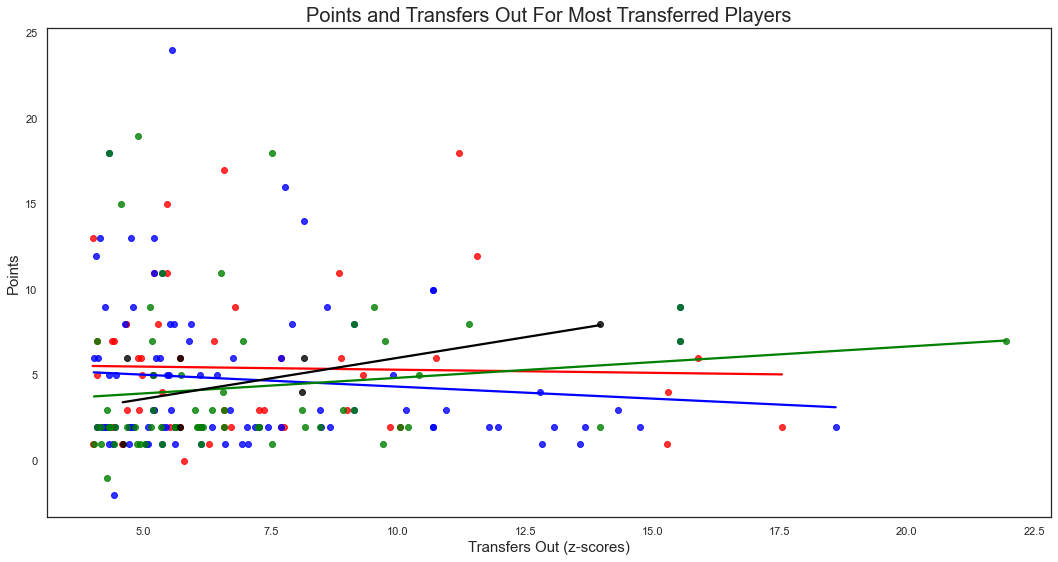

In [172]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

sns.regplot(
     top_merged_tout.groupby('opponent_strength').get_group(2)['z_score_transout'],top_merged_tout.groupby('opponent_strength').get_group(2)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'red'
)

sns.regplot(
     top_merged_tout.groupby('opponent_strength').get_group(3)['z_score_transout'],top_merged_tout.groupby('opponent_strength').get_group(3)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'blue'
)

sns.regplot(
     top_merged_tout.groupby('opponent_strength').get_group(4)['z_score_transout'],top_merged_tout.groupby('opponent_strength').get_group(4)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'green'
)

sns.regplot(
     top_merged_tout.groupby('opponent_strength').get_group(5)['z_score_transout'],top_merged_tout.groupby('opponent_strength').get_group(5)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'black'
)

ax.set_title('Points and Transfers Out For Most Transferred Players', fontsize = 20)
ax.set_xlabel('Transfers Out (z-scores)', fontsize = 15)
ax.set_ylabel('Points', fontsize = 15)
print(top_merged_tout.groupby('opponent_strength').get_group(5)['z_score_transout'].corr(top_merged_tout.groupby('opponent_strength').get_group(5)['total_points']))

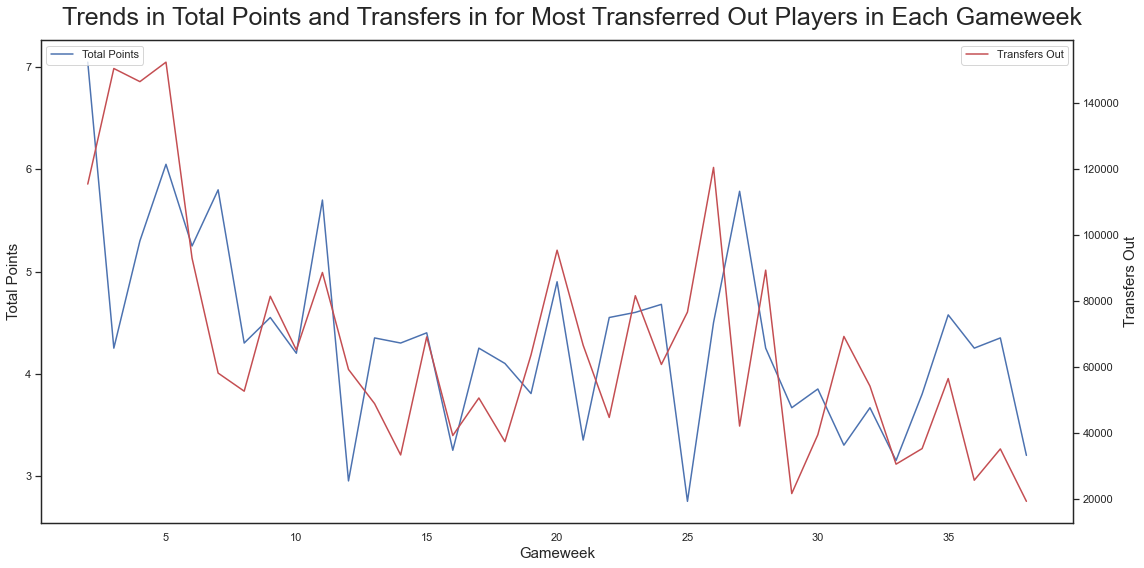

In [173]:
gw_info = gws_info.reset_index(drop=True)
merged_tout = merged_tout.sort_values(['gw', 'z_score_transout'], ascending=False).groupby('gw').head(20)
merged_tout = merged_tout[merged_tout['gw'] !=1]
df_out = (merged_tout.reset_index()[["name", "gw"]].merge(gw_info.reset_index(), on=["name", "gw"], how="inner"))
df_out = df_out.reset_index(drop=True).groupby('gw')

fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('Trends in Total Points and Transfers in for Most Transferred Out Players in Each Gameweek', fontsize=25)
plt.plot(df_out['total_points'].mean(), label = "Points")
plt.legend(['Total Points'], loc='upper left')
ax.set_xlabel('Gameweek', fontsize=15)
ax.set_ylabel('Total Points', fontsize=15)
ax2 = ax.twinx()
plt.plot(df_out['transfers_out'].mean(), label = "Transfers Out", color='r')
plt.legend(['Transfers Out'], loc='upper right')
ax2.set_ylabel('Transfers Out', fontsize=15)
ax2.tick_params()
fig.tight_layout()

# How Previous Weeks Points Affect Transfers in Next GW

In [174]:
trans_trends = gws_info[['gw', 'name', 'transfers_in', 'transfers_out', 'total_points', 'opponent_strength']]
next_gw = gws_info[['gw', 'name', 'transfers_in', 'transfers_out', 'total_points', 'opponent_strength']]
next_gw['gw'] = (next_gw['gw'] -1)
next_gw = next_gw[next_gw['gw'] != 0]
next_gw = next_gw.rename(columns = {'transfers_in':'next_gw_transfers_in','transfers_out':'next_gw_transfers_out'
                                    ,'total_points':'next_gw_total_points','opponent_strength':'next_opponent_strength'})
trans_trends = pd.merge(trans_trends, next_gw, on=['name','gw'])
trans_trends

C:\Users\phili\AppData\Local\Temp\ipykernel_9876\977668692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_gw['gw'] = (next_gw['gw'] -1)


,gw,name,transfers_in,transfers_out,total_points,opponent_strength,next_gw_transfers_in,next_gw_transfers_out,next_gw_total_points,next_opponent_strength
0,1,Pierre-Emerick Aubameyang,0.0,0.0,7.0,3,146991.0,223561.0,5.0,4
1,1,Alexandre Lacazette,0.0,0.0,7.0,3,93434.0,33483.0,7.0,4
2,1,Bernd Leno,0.0,0.0,7.0,3,112820.0,41552.0,2.0,4
3,1,Granit Xhaka,0.0,0.0,3.0,3,9879.0,9209.0,2.0,4
4,1,Héctor Bellerín,0.0,0.0,5.0,3,54450.0,31413.0,2.0,4
...,...,...,...,...,...,...,...,...,...,...
8178,37,Yves Bissouma,1733.0,3515.0,2.0,5,3721.0,3584.0,2.0,4
8179,37,Steven Alzate,10614.0,2201.0,2.0,5,19988.0,4128.0,1.0,4
8180,37,Alexis Mac Allister,25.0,53.0,2.0,5,100.0,58.0,2.0,4
8181,37,Robert Sánchez,2256.0,11669.0,0.0,5,4207.0,9968.0,2.0,4


C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

0.11240542631392032


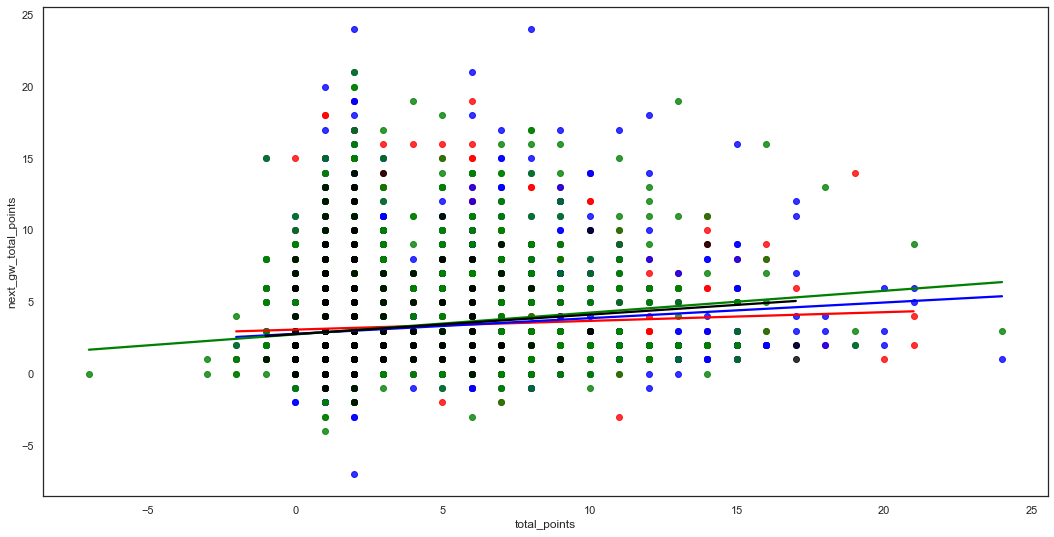

In [175]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

sns.regplot(
     trans_trends.groupby('opponent_strength').get_group(2)['total_points'],trans_trends.groupby('opponent_strength').get_group(2)['next_gw_total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'red'
)

sns.regplot(
     trans_trends.groupby('opponent_strength').get_group(3)['total_points'],trans_trends.groupby('opponent_strength').get_group(3)['next_gw_total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'blue'
)

sns.regplot(
     trans_trends.groupby('opponent_strength').get_group(4)['total_points'],trans_trends.groupby('opponent_strength').get_group(4)['next_gw_total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'green'
)

sns.regplot(
     trans_trends.groupby('opponent_strength').get_group(5)['total_points'],trans_trends.groupby('opponent_strength').get_group(5)['next_gw_total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'black'
)

print(trans_trends.groupby('opponent_strength').get_group(3)['total_points'].corr(trans_trends.groupby('opponent_strength').get_group(3)['next_gw_total_points']))

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_points', ylabel='next_gw_transfers_in'>

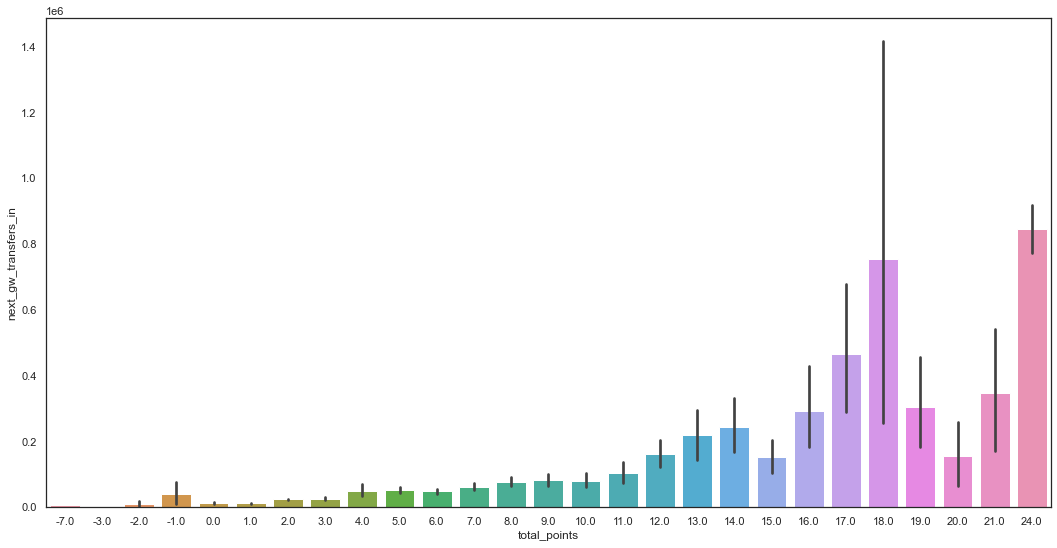

In [176]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

sns.barplot(
     trans_trends['total_points'],trans_trends['next_gw_transfers_in'], ax=ax
)

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_points', ylabel='next_gw_transfers_out'>

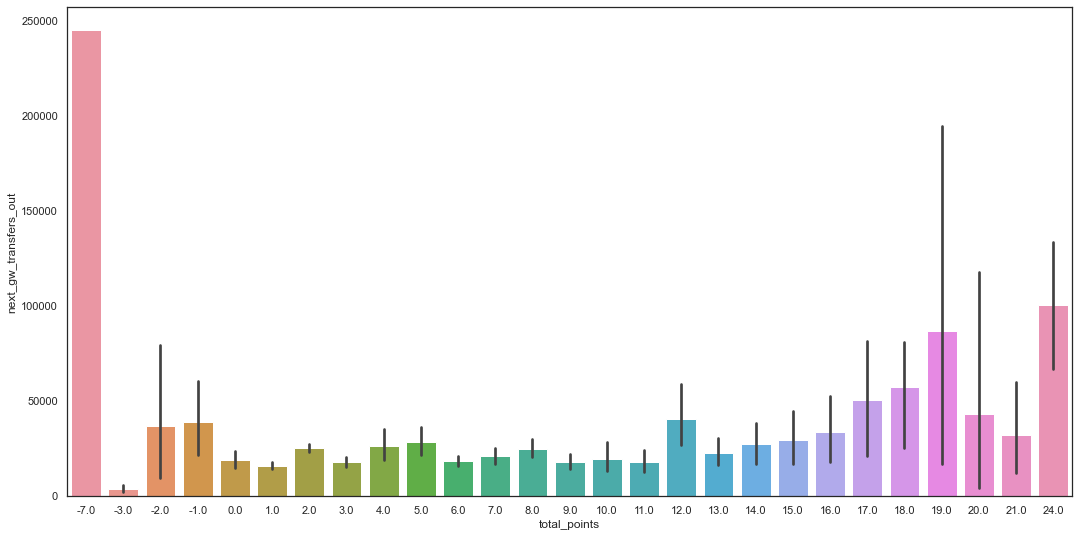

In [177]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.barplot(
     trans_trends['total_points'],trans_trends['next_gw_transfers_out'], ax=ax
)

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

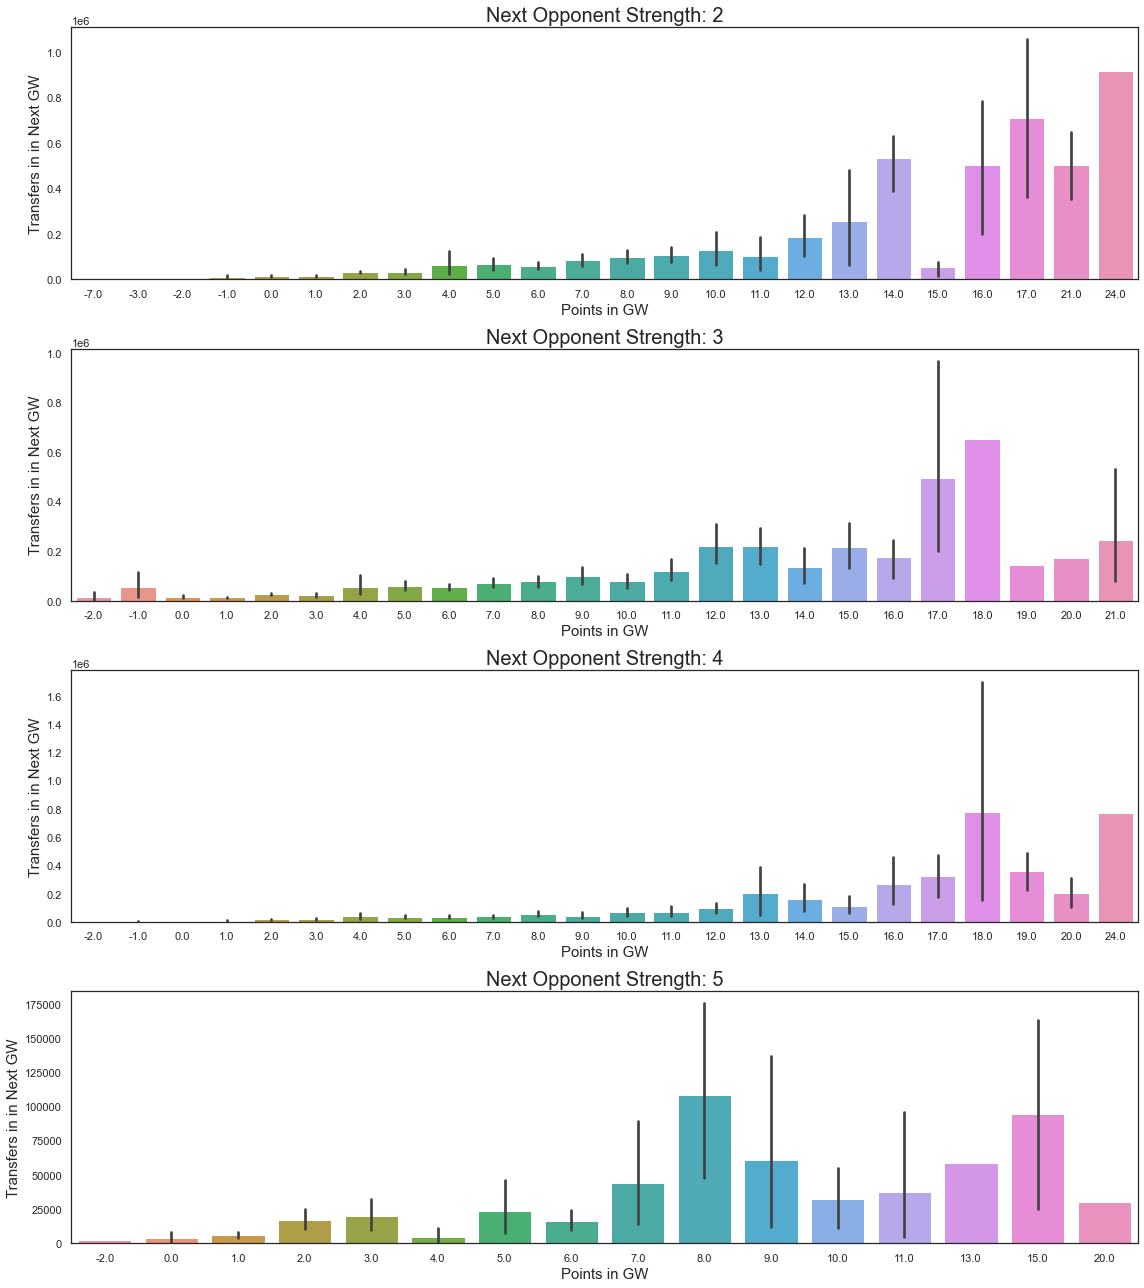

In [178]:
fig, ax = plt.subplots(4,1,figsize=(16, 18))
sns.barplot(
     trans_trends.groupby('next_opponent_strength').get_group(2)['total_points'],
    trans_trends.groupby('next_opponent_strength').get_group(2)['next_gw_transfers_in'], ax=ax[0]
)

sns.barplot(
     trans_trends.groupby('next_opponent_strength').get_group(3)['total_points'],
    trans_trends.groupby('next_opponent_strength').get_group(3)['next_gw_transfers_in'], ax=ax[1]
)

sns.barplot(
     trans_trends.groupby('next_opponent_strength').get_group(4)['total_points'],
    trans_trends.groupby('next_opponent_strength').get_group(4)['next_gw_transfers_in'], ax=ax[2]
)

sns.barplot(
     trans_trends.groupby('next_opponent_strength').get_group(5)['total_points'],
    trans_trends.groupby('next_opponent_strength').get_group(5)['next_gw_transfers_in'], ax=ax[3]
)

ax[0].set_title('Next Opponent Strength: 2', fontsize=20)
ax[0].set_xlabel('Points in GW', fontsize = 15)
ax[0].set_ylabel('Transfers in in Next GW', fontsize = 15)

ax[1].set_title('Next Opponent Strength: 3', fontsize=20)
ax[1].set_xlabel('Points in GW', fontsize = 15)
ax[1].set_ylabel('Transfers in in Next GW', fontsize = 15)

ax[2].set_title('Next Opponent Strength: 4', fontsize=20)
ax[2].set_xlabel('Points in GW', fontsize = 15)
ax[2].set_ylabel('Transfers in in Next GW', fontsize = 15)

ax[3].set_title('Next Opponent Strength: 5', fontsize=20)
ax[3].set_xlabel('Points in GW', fontsize = 15)
ax[3].set_ylabel('Transfers in in Next GW', fontsize = 15)

fig.tight_layout()

# Is the Expected Points Metric Worth Using

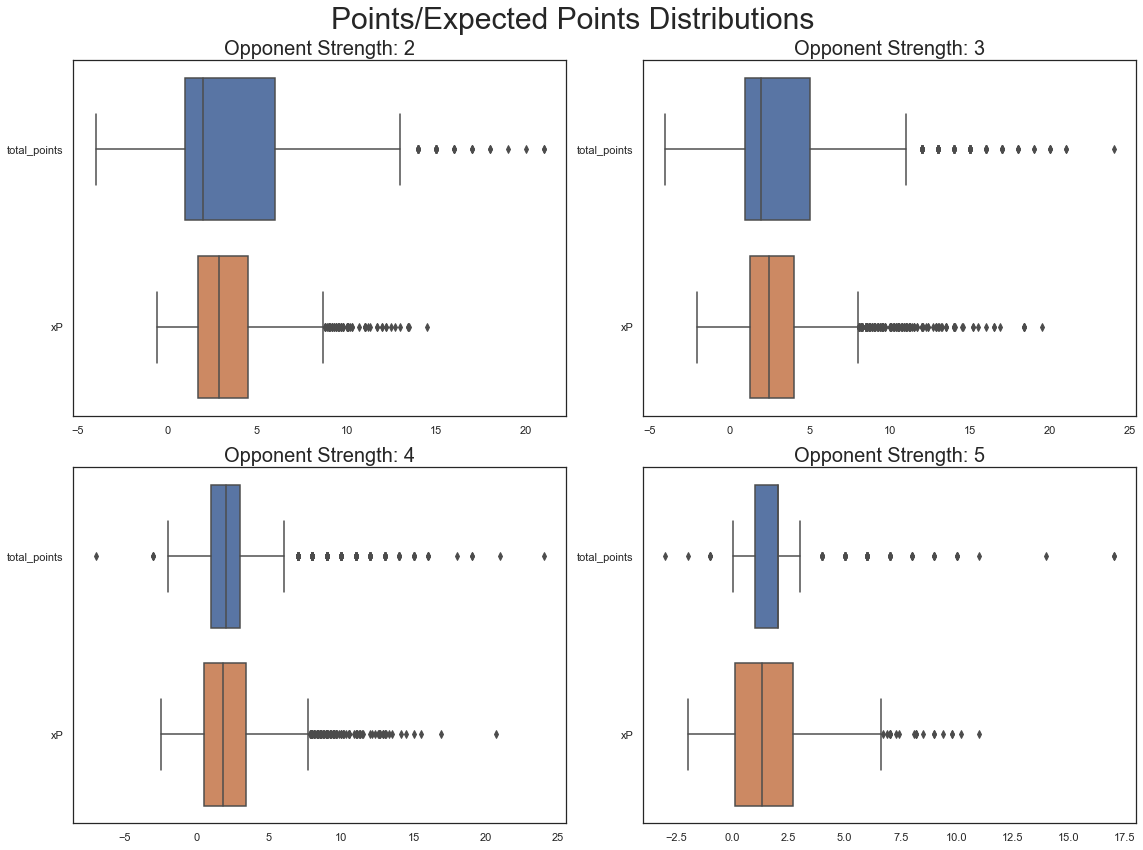

In [179]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

plt.suptitle('Points/Expected Points Distributions', fontsize=30)

axs[0, 0].set_title('Opponent Strength: 2', fontsize = 20)
axs[0, 1].set_title('Opponent Strength: 3', fontsize = 20)
axs[1, 0].set_title('Opponent Strength: 4', fontsize = 20)
axs[1, 1].set_title('Opponent Strength: 5', fontsize = 20)

sns.boxplot(data= gws_info.groupby('opponent_strength').get_group(2)[['total_points','xP']], orient='h', ax=axs[0,0])
sns.boxplot(data= gws_info.groupby('opponent_strength').get_group(3)[['total_points','xP']], orient='h', ax=axs[0,1])
sns.boxplot(data= gws_info.groupby('opponent_strength').get_group(4)[['total_points','xP']], orient='h', ax=axs[1,0])
sns.boxplot(data= gws_info.groupby('opponent_strength').get_group(5)[['total_points','xP']], orient='h', ax=axs[1,1])
fig.tight_layout()

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

0.5194713905312387


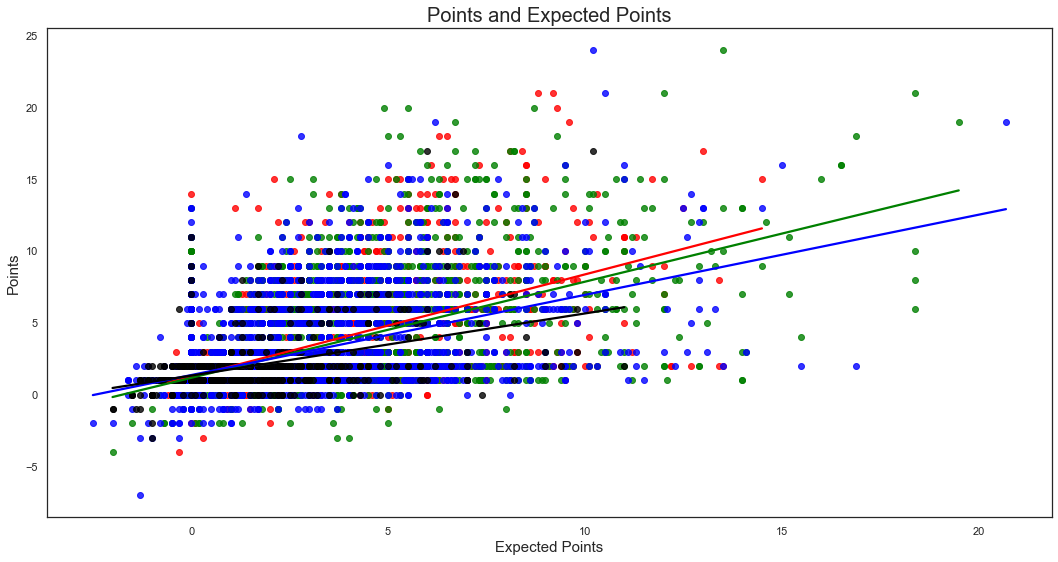

In [180]:
fig, ax = plt.subplots(figsize=(18, 9))

bbox = dict(boxstyle ="round", fc ="0.8")

gws_infoxp = gws_info

sns.regplot(
    gws_infoxp.groupby('opponent_strength').get_group(2)['xP'], gws_infoxp.groupby('opponent_strength').get_group(2)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'red'
)

sns.regplot(
    gws_infoxp.groupby('opponent_strength').get_group(3)['xP'], gws_infoxp.groupby('opponent_strength').get_group(3)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'green'
)

sns.regplot(
    gws_infoxp.groupby('opponent_strength').get_group(4)['xP'], gws_infoxp.groupby('opponent_strength').get_group(4)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'blue'
)

sns.regplot(
    gws_infoxp.groupby('opponent_strength').get_group(5)['xP'], gws_infoxp.groupby('opponent_strength').get_group(5)['total_points'],
    ax=ax, ci=False, marker='o',fit_reg=True, color = 'black'
)
ax.set_title('Points and Expected Points', fontsize = 20)
ax.set_xlabel('Expected Points', fontsize = 15)
ax.set_ylabel('Points', fontsize = 15)

print(gws_infoxp['xP'].corr(gws_infoxp['total_points']))

C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\phili\anacond

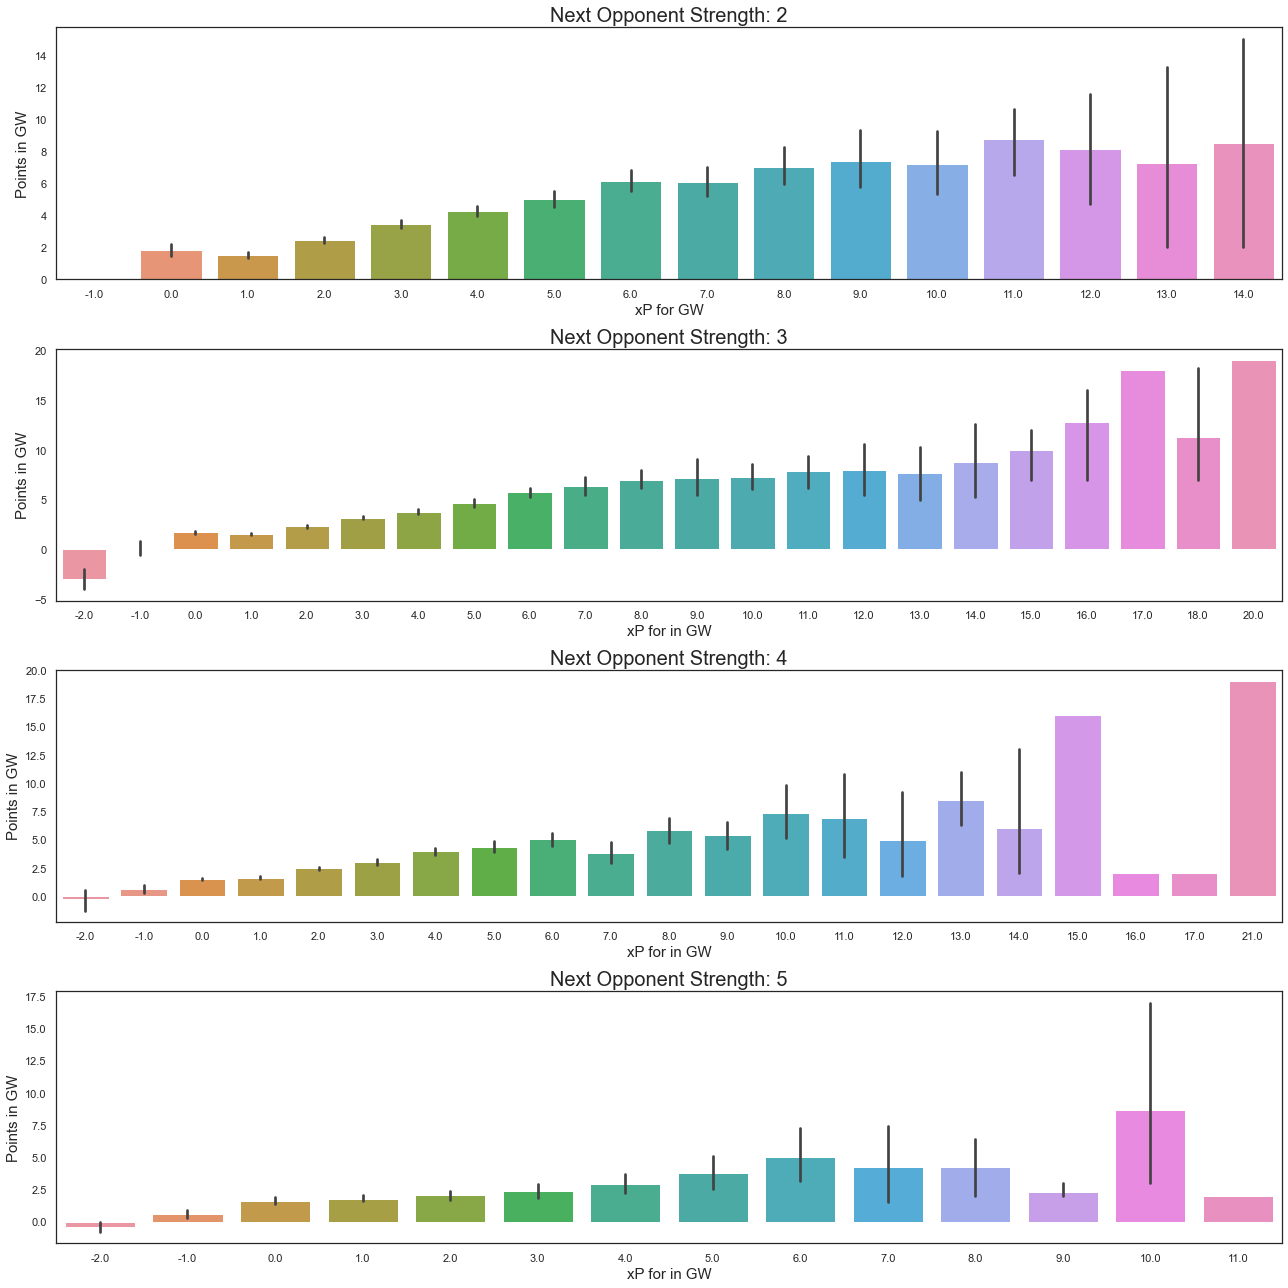

In [181]:
fig, ax = plt.subplots(4,1,figsize=(18, 18))
sns.barplot(
     round(gws_info.groupby('opponent_strength').get_group(2)['xP']),
    gws_info.groupby('opponent_strength').get_group(2)['total_points'], ax=ax[0]
)

sns.barplot(
     round(gws_info.groupby('opponent_strength').get_group(3)['xP']),
    gws_info.groupby('opponent_strength').get_group(3)['total_points'], ax=ax[1]
)

sns.barplot(
     round(gws_info.groupby('opponent_strength').get_group(4)['xP']),
    gws_info.groupby('opponent_strength').get_group(4)['total_points'], ax=ax[2]
)

sns.barplot(
     round(gws_info.groupby('opponent_strength').get_group(5)['xP']),
    gws_info.groupby('opponent_strength').get_group(5)['total_points'], ax=ax[3]
)

ax[0].set_title('Next Opponent Strength: 2', fontsize=20)
ax[0].set_xlabel('xP for GW', fontsize = 15)
ax[0].set_ylabel('Points in GW', fontsize = 15)

ax[1].set_title('Next Opponent Strength: 3', fontsize=20)
ax[1].set_xlabel('xP for in GW', fontsize = 15)
ax[1].set_ylabel('Points in GW', fontsize = 15)

ax[2].set_title('Next Opponent Strength: 4', fontsize=20)
ax[2].set_xlabel('xP for in GW', fontsize = 15)
ax[2].set_ylabel('Points in GW', fontsize = 15)

ax[3].set_title('Next Opponent Strength: 5', fontsize=20)
ax[3].set_xlabel('xP for in GW', fontsize = 15)
ax[3].set_ylabel('Points in GW', fontsize = 15)

fig.tight_layout()